# MNIST画像認識のtorch model ハイパーパラメータチューニング


### チューニングを行うハイパーパラメータ
- 畳み込み層の数
- 各畳み込み層のフィルタ数
- 全結合層のユニット数
- 活性化関数
- 最適化手法
- 学習率
- weight_decay

## パラメータチューニングを楽にする方法
上のハイパラをチューニングすることで良い性能が得られる可能性がある.
しかしハイパラメータのチューニングはネットワークの性質と元データやタスクに関する情報から推測されるものであり、自動化を行わなければ複数結果を比較して最善と思われるものを自身で決定しなければならない. 
その個人的な意志力が介在するのはデータ分析的には好ましくないために自動化する必要がある．
そこで今回はOptunaを採用し、パイパラチューニングを効率的に行う．



## Load Dataset

In [1]:
import datetime
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from optuna.integration.tensorboard import TensorBoardCallback
import optuna
optuna.logging.disable_default_handler()


#set seeds
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

torch_fix_seed()


BATCHSIZE = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=BATCHSIZE, shuffle=True, num_workers=2)

test_set = MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))


2023-07-14 21:29:44.521730: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-14 21:29:44.545962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 21:29:45.067005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Define Model

In [2]:
#モデルの定義

#入力画像の高さと幅，畳み込み層のカーネルサイズ
in_height = 28
in_width = 28
kernel = 3

class Net(nn.Module):
  def __init__(self, trial, num_layer, mid_units, num_filters):
    super(Net, self).__init__()
    self.activation = get_activation(trial)
    #第1層
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=num_filters[0], kernel_size=3)])
    self.out_height = in_height - kernel +1
    self.out_width = in_width - kernel +1
    #第2層以降
    for i in range(1, num_layer):
      self.convs.append(nn.Conv2d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=3))
      self.out_height = self.out_height - kernel + 1
      self.out_width = self.out_width - kernel +1
    #pooling層
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.out_height = int(self.out_height / 2)
    self.out_width = int(self.out_width / 2)
    #線形層
    self.out_feature = self.out_height * self.out_width * num_filters[num_layer - 1]
    self.fc1 = nn.Linear(in_features=self.out_feature, out_features=mid_units) 
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)
    
  def forward(self, x):
    for i, l in enumerate(self.convs):
      x = l(x)
      x = self.activation(x)
    x = self.pool(x)
    x = x.view(-1, self.out_feature)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

## Train & Test

In [3]:
def train(model, device, train_loader, optimizer):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 1 - correct / len(test_loader.dataset)


## Tune Optimaisation

In [4]:
def get_optimizer(trial, model):
  optimizer_names = ['Adam', 'MomentumSGD', 'rmsprop']
  optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
  
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
  
  if optimizer_name == optimizer_names[0]: 
    adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
    optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
  elif optimizer_name == optimizer_names[1]:
    momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
    optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr, momentum=0.9, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters())
  
  return optimizer

## Tune activate function

In [5]:
def get_activation(trial):
    activation_names = ['ReLU', 'ELU']
    activation_name = trial.suggest_categorical('activation', activation_names)
    
    if activation_name == activation_names[0]:
        activation = F.relu
    else:
        activation = F.elu
    
    return activation


## Set the object function

In [6]:
EPOCH = 10
def objective(trial):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f'device == {device}')
  
  #畳み込み層の数
  num_layer = trial.suggest_int('num_layer', 3, 7)
  
  #FC層のユニット数
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 500, 100))
  
  #各畳込み層のフィルタ数
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]
  
  model = Net(trial, num_layer, mid_units, num_filters).to(device)
  optimizer = get_optimizer(trial, model)
  
  for step in range(EPOCH):
    train(model, device, train_loader, optimizer)
    error_rate = test(model, device, test_loader)
    print(f'{step}fin | error rate {error_rate}')

  print(f'{trial.number + 1} trial fin')
  return error_rate



## Execution

In [7]:
from optuna.integration.tensorboard import TensorBoardCallback

TRIAL_SIZE = 50
tensorboard_callback = TensorBoardCallback(f"logs/MNIST/{datetime.datetime.now()}/Optuna/", metric_name="error_rate")
study = optuna.create_study()
study.optimize(objective, n_trials=TRIAL_SIZE, callbacks=[tensorboard_callback])
# ipdb.set_trace()


/tmp/ipykernel_78/56581319.py:4: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
  tensorboard_callback = TensorBoardCallback(f"logs/MNIST/{datetime.datetime.now()}/Optuna/", metric_name="error_rate")
/tmp/ipykernel_78/3690163298.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  mid_units = int(trial.suggest_discrete_uniform("mid_units", 100, 500, 100))
/tmp/ipykernel_78/3690163298.py:13: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_layer)]


device == cuda


/tmp/ipykernel_78/2611439263.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)


0fin | error rate 0.8865
1fin | error rate 0.8865
2fin | error rate 0.8865
3fin | error rate 0.899
4fin | error rate 0.8865
5fin | error rate 0.8865
6fin | error rate 0.899
7fin | error rate 0.8968
8fin | error rate 0.8968
9fin | error rate 0.8865
1 trial fin
device == cuda


2023-07-14 21:30:39.660253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 21:30:39.660745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 21:30:39.660815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

0fin | error rate 0.8972
1fin | error rate 0.902
2fin | error rate 0.8991
3fin | error rate 0.9108
4fin | error rate 0.8865
5fin | error rate 0.899
6fin | error rate 0.8972
7fin | error rate 0.8865
8fin | error rate 0.9042
9fin | error rate 0.8968
2 trial fin
device == cuda
0fin | error rate 0.8972
1fin | error rate 0.9042
2fin | error rate 0.8991
3fin | error rate 0.9108
4fin | error rate 0.899
5fin | error rate 0.8865
6fin | error rate 0.9042
7fin | error rate 0.8972
8fin | error rate 0.8968
9fin | error rate 0.899
3 trial fin
device == cuda
0fin | error rate 0.8421
1fin | error rate 0.8972
2fin | error rate 0.8972
3fin | error rate 0.9018
4fin | error rate 0.8972
5fin | error rate 0.8968
6fin | error rate 0.8972
7fin | error rate 0.8968
8fin | error rate 0.9026
9fin | error rate 0.9108
4 trial fin
device == cuda


/tmp/ipykernel_78/2611439263.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)


0fin | error rate 0.10129999999999995
1fin | error rate 0.0867
2fin | error rate 0.0686
3fin | error rate 0.04800000000000004
4fin | error rate 0.03469999999999995
5fin | error rate 0.02959999999999996
6fin | error rate 0.0242
7fin | error rate 0.021399999999999975
8fin | error rate 0.018000000000000016
9fin | error rate 0.01880000000000004
5 trial fin
device == cuda
0fin | error rate 0.8865
1fin | error rate 0.8865
2fin | error rate 0.8865
3fin | error rate 0.8865
4fin | error rate 0.8968
5fin | error rate 0.8968
6fin | error rate 0.8865
7fin | error rate 0.8865
8fin | error rate 0.8865
9fin | error rate 0.8865
6 trial fin
device == cuda
0fin | error rate 0.8865
1fin | error rate 0.8968
2fin | error rate 0.8865
3fin | error rate 0.8865
4fin | error rate 0.9018
5fin | error rate 0.9018
6fin | error rate 0.8968
7fin | error rate 0.8865
8fin | error rate 0.899
9fin | error rate 0.8865
7 trial fin
device == cuda
0fin | error rate 0.899
1fin | error rate 0.8968
2fin | error rate 0.902
3fin

2fin | error rate 0.902
3fin | error rate 0.902
4fin | error rate 0.902
5fin | error rate 0.902
6fin | error rate 0.902
7fin | error rate 0.902
8fin | error rate 0.902
9fin | error rate 0.902
27 trial fin
device == cuda
0fin | error rate 0.023900000000000032
1fin | error rate 0.01749999999999996
2fin | error rate 0.018399999999999972
3fin | error rate 0.012700000000000045
4fin | error rate 0.011600000000000055
5fin | error rate 0.012299999999999978
6fin | error rate 0.015599999999999947
7fin | error rate 0.009800000000000031
8fin | error rate 0.0131
9fin | error rate 0.011900000000000022
28 trial fin
device == cuda
0fin | error rate 0.7495
1fin | error rate 0.9026
2fin | error rate 0.902
3fin | error rate 0.8968
4fin | error rate 0.902
5fin | error rate 0.9026
6fin | error rate 0.9018
7fin | error rate 0.902
8fin | error rate 0.9042
9fin | error rate 0.9108
29 trial fin
device == cuda
0fin | error rate 0.11360000000000003
1fin | error rate 0.09340000000000004
2fin | error rate 0.080999

0fin | error rate 0.01649999999999996
1fin | error rate 0.0121
2fin | error rate 0.012599999999999945
3fin | error rate 0.01200000000000001
4fin | error rate 0.00880000000000003
5fin | error rate 0.009600000000000053
6fin | error rate 0.008700000000000041
7fin | error rate 0.008499999999999952
8fin | error rate 0.010000000000000009
9fin | error rate 0.00880000000000003
48 trial fin
device == cuda
0fin | error rate 0.015499999999999958
1fin | error rate 0.011600000000000055
2fin | error rate 0.011700000000000044
3fin | error rate 0.009000000000000008
4fin | error rate 0.01100000000000001
5fin | error rate 0.011199999999999988
6fin | error rate 0.010199999999999987
7fin | error rate 0.009700000000000042
8fin | error rate 0.008199999999999985
9fin | error rate 0.008299999999999974
49 trial fin
device == cuda
0fin | error rate 0.8865
1fin | error rate 0.8865
2fin | error rate 0.8865
3fin | error rate 0.8865
4fin | error rate 0.8865
5fin | error rate 0.8865
6fin | error rate 0.8865
7fin | e

In [8]:
print(study.best_params)
print(study.best_value)

{'num_layer': 7, 'mid_units': 200.0, 'num_filter_0': 96.0, 'num_filter_1': 128.0, 'num_filter_2': 16.0, 'num_filter_3': 96.0, 'num_filter_4': 16.0, 'num_filter_5': 128.0, 'num_filter_6': 112.0, 'activation': 'ReLU', 'optimizer': 'Adam', 'weight_decay': 7.476752114900737e-10, 'adam_lr': 0.0009024344882605248}
0.008199999999999985


このOptunaを用いたパラメータ探索に関しては ./Optuna_MNIST.py で実装を行ったそのため以下のコマンドを実行すると学習およびパラメータ探索が開始される．
結果はtensorbord上で確認できるため
以下のコマンドを実行する必要がある
```
tensorboard --logdir /root/src/logs/MNIST/<実行した日時>/Optuna --host 0.0.0.0 --port 6006
```
そしてtensorboardの起動を確認後、左上のタブにおいてHPARAMSという欄がある.この欄を選択すると画面が切り替わる. その後, 画面中央のPARALLEL COORDINATES VIEWを選択することで下記の画像を確認できる. 
このグラフは各ハイパラメータと結果の関係をグラフ化したもので，このグラフから各ハイパラメータがどのように結果に対して寄与しているのかを確認できる

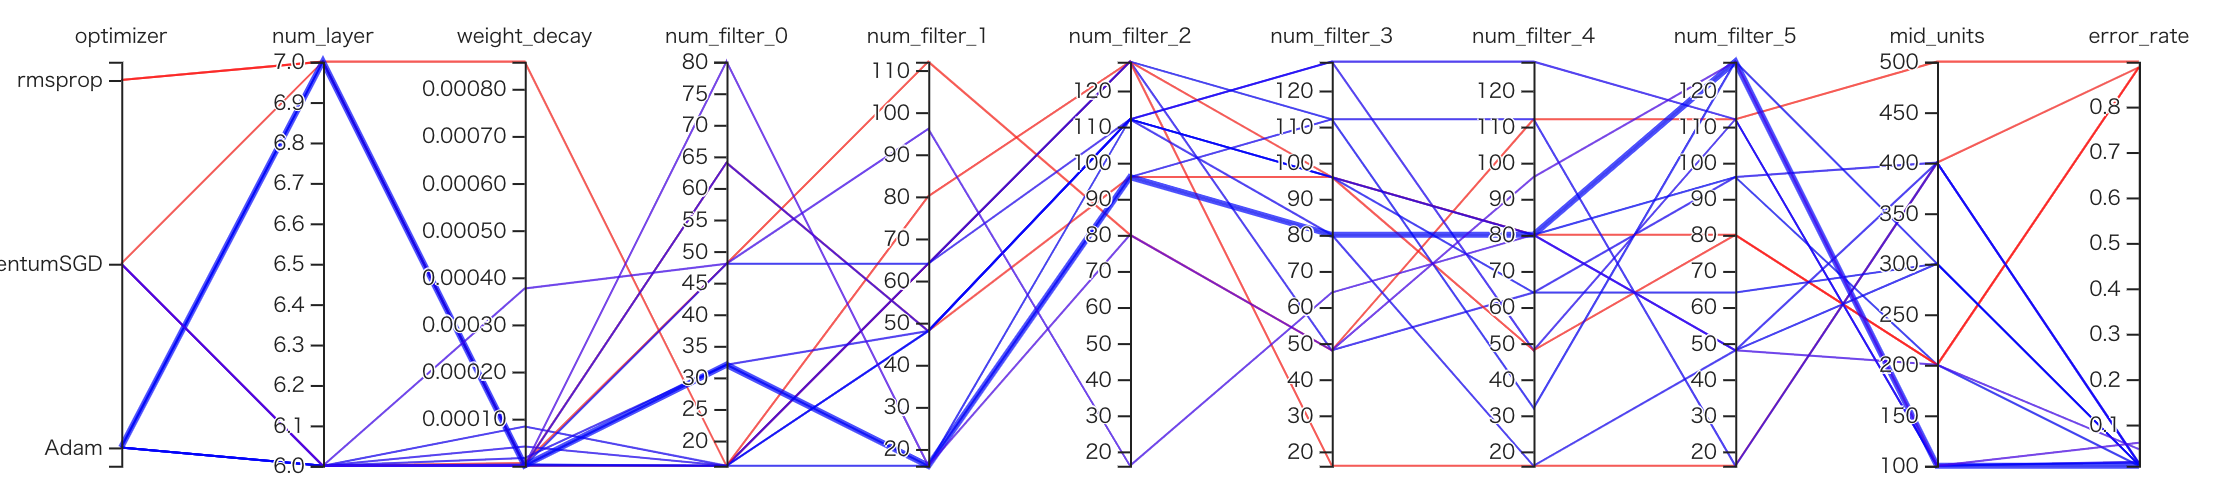

In [9]:
from PIL import Image
img=Image.open("MNIST.png")
img

以上の写真からわかることは各パラーメータ値とそのパラメータ設定で推論を行った時の精度である．
errorrateと他パラメータの関係として以下のことが挙げられる

- 最適化手法(optimizer)は、今回の探索結果において、"MomentumSGD"と"Adam"が多数採用され、エラー率が低くなった． 
- フィルター数は、5-7が採用されており、畳み込み層は比較的多い方が精度が良くなることがわかった．
- 全結合層のユニット数は、100-500が採用されているが、500を超えると精度が急激に悪くなることから、400より下回ること好ましいと言え、最適パラメータとしては、100以下であることも考えらえる．

以上のことから、今回の最適パラメータ選択において特徴的な点は以下のことが言える．
- 最適化手法: "MomentumSGD"と"Adam"
- 畳み込み層の数: 6
- 全結合層のユニット数:400以下


Optunaには最適パラメータを保持する機能があり，その保持パラーメータとそのハイパラで組まれたネットワークのerror rateが出力できる．
この結果より発見されたパラメータは

{'num_layer': 6, 'mid_units': 400.0, 'num_filter_0': 128.0, 'num_filter_1': 112.0, 'num_filter_2': 128.0, 'num_filter_3': 32.0, 'num_filter_4': 64.0, 'num_filter_5': 16.0, 'activation': 'ELU', 'optimizer': 'MomentumSGD', 'weight_decay': 3.705858691297322e-09, 'momentum_sgd_lr': 0.014335285805707738}


であり，そのネットワークでのerror rateは 0.015100


以下のように、調整前よりも性能が上がっていることが確認できる．


【最適なパラメータ調整を行なった実行】

0fin | error rate 0.022800000000000042

1fin | error rate 0.017100000000000004

2fin | error rate 0.011700000000000044

3fin | error rate 0.01429999999999998

4fin | error rate 0.011600000000000055

5fin | error rate 0.011399999999999966

6fin | error rate 0.010099999999999998

7fin | error rate 0.010499999999999954

8fin | error rate 0.00990000000000002

9fin | error rate 0.011099999999999999


【不適切なパラメータ調整を行った実行】

0fin | error rate 0.022700000000000053

1fin | error rate 0.014599999999999946

2fin | error rate 0.015499999999999958

3fin | error rate 0.013900000000000023

4fin | error rate 0.01419999999999999

5fin | error rate 0.0131

6fin | error rate 0.012499999999999956

7fin | error rate 0.011800000000000033

8fin | error rate 0.011800000000000033

9fin | error rate 0.013599999999999945


|